# The main task is looking for dependation between 3 data type: average month temperature and month number vs. month electricity energy usage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
energy = pd.read_csv('elusage.csv', index_col = False)

In [3]:
energy.head(10)

,average_temperature,month,average_electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667
5,41,1,49.333
6,38,2,59.375
7,46,3,55.172
8,54,4,55.517
9,60,5,25.938


### Getting informations about DataFrame (e.g. inproper/missing values and types of data used)

In [4]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   average_temperature        55 non-null     int64  
 1   month                      55 non-null     int64  
 2   average_electricity_usage  55 non-null     float64
dtypes: float64(1), int64(2)
memory usage: 1.4 KB


#### **There are no missing values and all of them are numeric types**

### After DataFrame was made and check we need to give it as simple form as possible, so we will make column names shorter by removing useless `'average_'` substring (we know that every number in these 2 columns are the average values calculated from many observations taken during every month).

In [5]:
energy = energy.rename(columns={'average_temperature': 'temperature',
                                'average_electricity_usage': 'electricity_usage'})
energy.head()

,temperature,month,electricity_usage
0,73,8,24.828
1,67,9,24.688
2,57,10,19.310
3,43,11,59.706
4,26,12,99.667


---

## Global plot settings as a function

In [6]:
def global_plot_sets():
    plt.rc('xtick', color = 'k', labelsize = 18)
    plt.rc('ytick', color = 'k', labelsize = 18)
    plt.rc('axes', labelsize = 24, labelpad = 18, titlepad = 12,
           titlesize = 28, facecolor = '#c6c6c6', axisbelow = 'True')
    plt.rc('grid', color = 'w', linestyle = '-.', linewidth = 0.6)
    plt.rc('legend', facecolor = 'w', fontsize = 16)
    plt.rc('xtick.major', size = 8, width = 1)
    plt.rc('xtick.minor', size = 5, width = 1)
    plt.rc('ytick.major', size = 8, width = 1)
    plt.rc('ytick.minor', size = 5, width = 1)

## Plots displaying dependancy between measured data

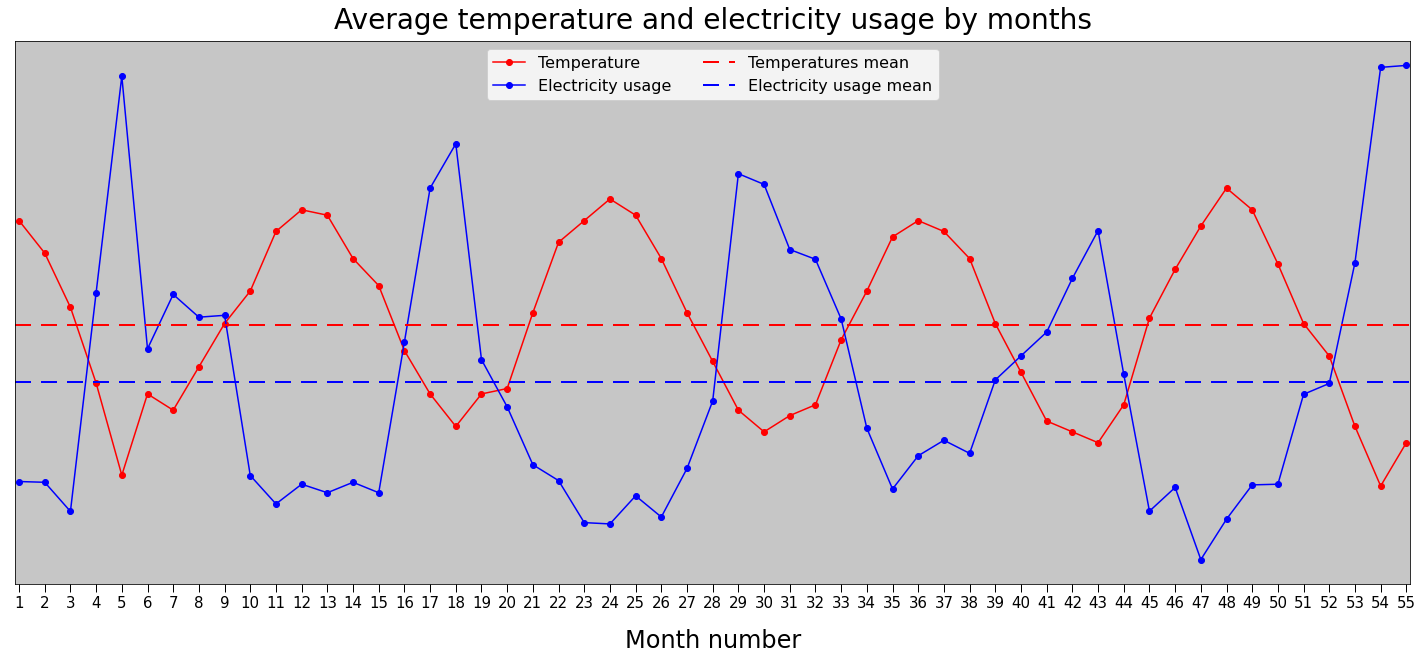

In [7]:
global_plot_sets()
plt.figure(figsize=(25, 10))

# Number of observations in the column
x_range = np.arange(1, energy.shape[0] + 1)

plt.plot(x_range, energy['temperature'], c = 'red', marker = 'o', label = 'Temperature')
plt.plot(x_range, energy['electricity_usage'], c = 'blue', marker = 'o', label = 'Electricity usage')
plt.xlabel('Month number')
plt.xlim(x_range.min() - 0.15, x_range.max() + 0.15)
plt.xticks(x_range, fontsize=15)
plt.yticks([]) ## no vertical axis
plt.grid([])   ## no grid - it makes plot easier to read
plt.axhline(y=np.mean(energy['temperature']), color = 'red', ls=(0, (8,5)), lw=2, label='Temperatures mean')
plt.axhline(y=np.mean(energy['electricity_usage']), color = 'blue', ls=(0, (8,5)), lw=2, label='Electricity usage mean')
plt.title('Average temperature and electricity usage by months')
plt.legend(loc='upper center', ncol=2)  ## legend descriptions divide into 2 columns

plt.show()

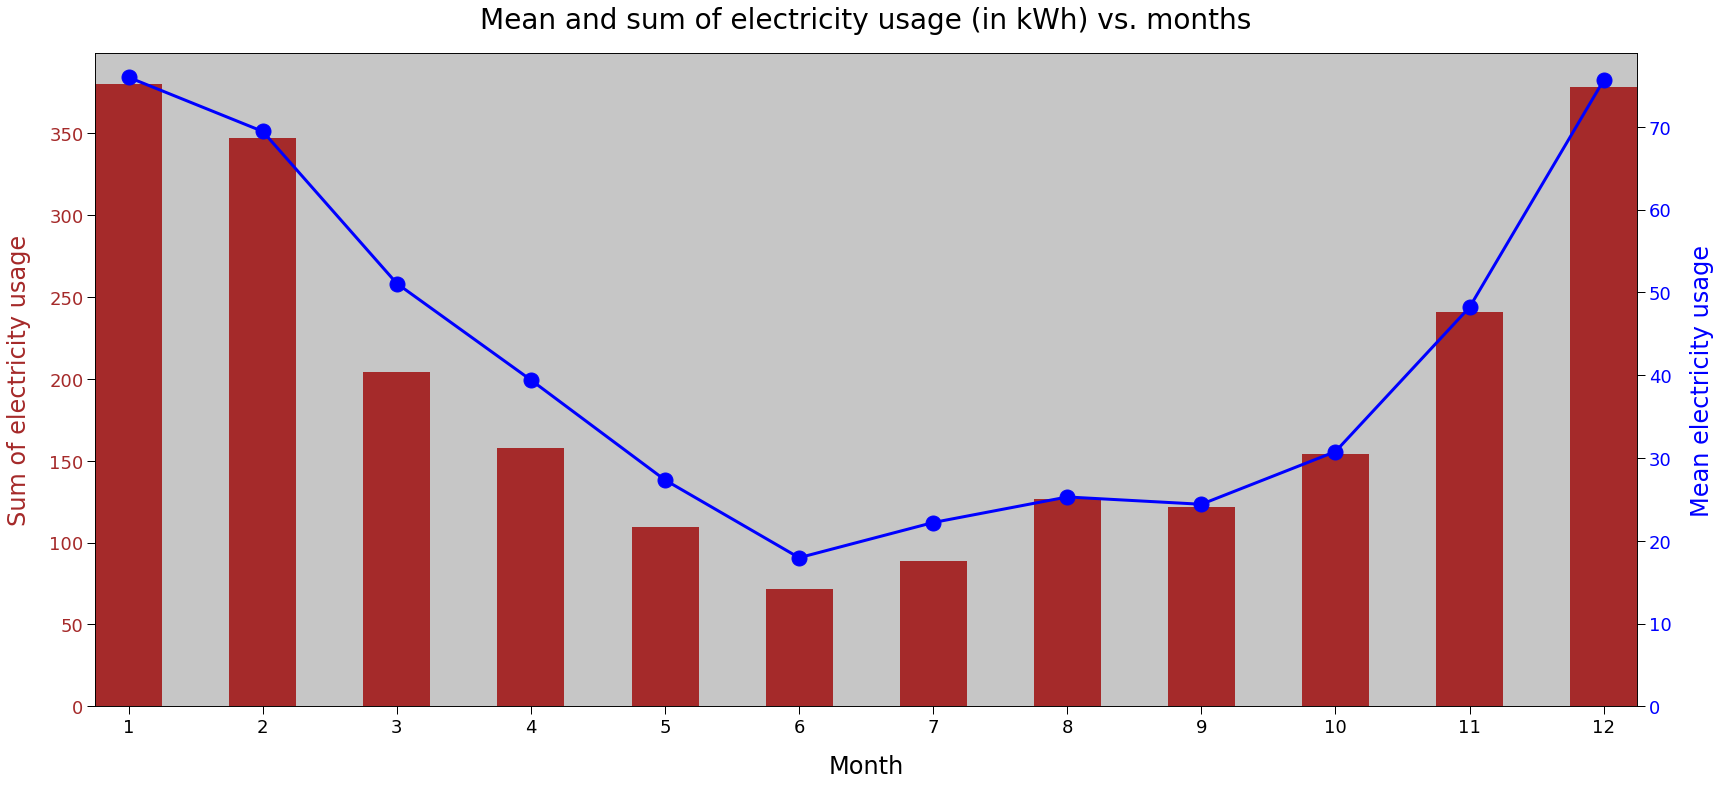

In [8]:
fig, ax1 = plt.subplots(figsize=(24, 11))
ax2 = ax1.twinx()

# Mean and sum values for every month of the year
months_mean_energy_used = energy.groupby('month')['electricity_usage'].mean()
months_sum_energy_used = energy.groupby('month')['electricity_usage'].sum()

month_number = months_sum_energy_used.keys()
w = 0.5   # bar width

ax1.bar(month_number, months_sum_energy_used, width = w, color = 'brown', linewidth=0)
ax2.plot(month_number, months_mean_energy_used, color = 'blue', linewidth=3, marker='o', markersize=15)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum of electricity usage', color='brown')
ax1.set_xlim((min(month_number)-0.5*w, max(month_number)+0.5*w))
ax1.tick_params(axis='y', labelcolor='brown')
ax1.set_xticks(month_number)    
ax2.set_ylabel('Mean electricity usage', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(ymin=0)
plt.title('Mean and sum of electricity usage (in kWh) vs. months', y=1.02)

fig.tight_layout()
plt.show()

***

## Looking for *Pearson* and *Spearman correlation*

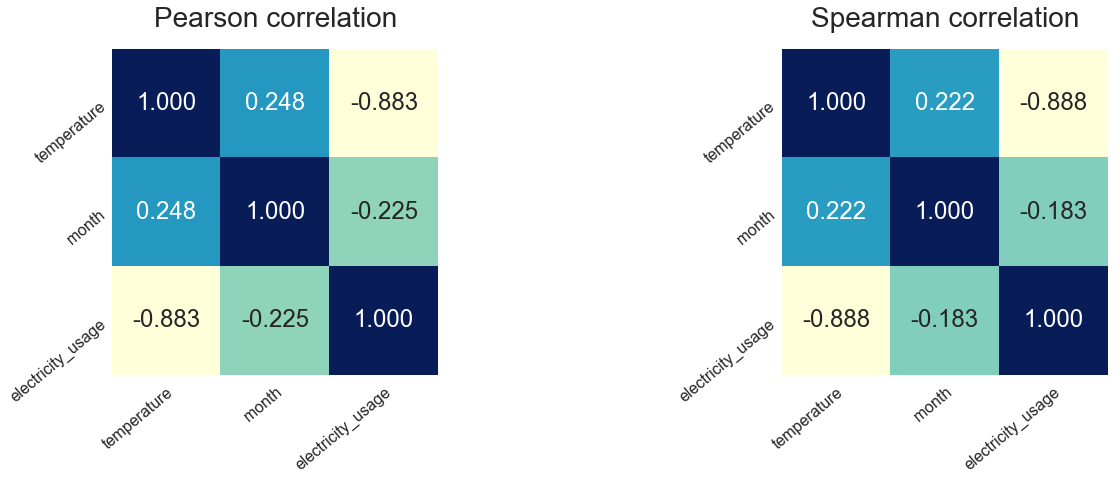

In [9]:
sns.set()

# Draw a heatmap with the numeric values in each cell
fig = plt.figure(figsize=(22, 6))

ax_ = [fig.add_subplot(1, 2, pos) for pos in [1,2]]
correlation_data = [energy.corr(method = option) for option in ['pearson', 'spearman']]
titles_array = ['Pearson correlation', 'Spearman correlation']

# We use 'axs' parameter to tell seaborn which subplot to use for each plot
for axs, data, titles in zip(ax_, correlation_data, titles_array):
    sns.heatmap(data = data, square = True, cmap = "YlGnBu", cbar=False,
                fmt = '.3f', annot = True, annot_kws = {"fontsize": 24}, ax = axs)
    axs.set_xticklabels(ax_[0].get_xticklabels(), fontsize = 16,
                        rotation = 40, ha = "right", rotation_mode = "anchor")
    axs.set_yticklabels(ax_[0].get_xticklabels(), fontsize = 16,
                        rotation = 40, ha = "right", rotation_mode = "anchor")
    axs.set_title(titles, fontsize = 28, y=1.03)
    
plt.show()

## **Conclusions:** 
### - `'month'` vs. `'electricity usage'` do not have enough strong linear and non-linear correlations, although plot show their cyclical (seasonal) dependancy,
### - `'temperature'` and `'electricity_usage'` have got strong ***Spearman correlation***, so regression will be made using linear algorythms and with decision tree.

---

# **Statistics for data set**

## Compare basic stats for `'temperature'` and `'electricity_usage'` data

<Figure size 432x288 with 0 Axes>

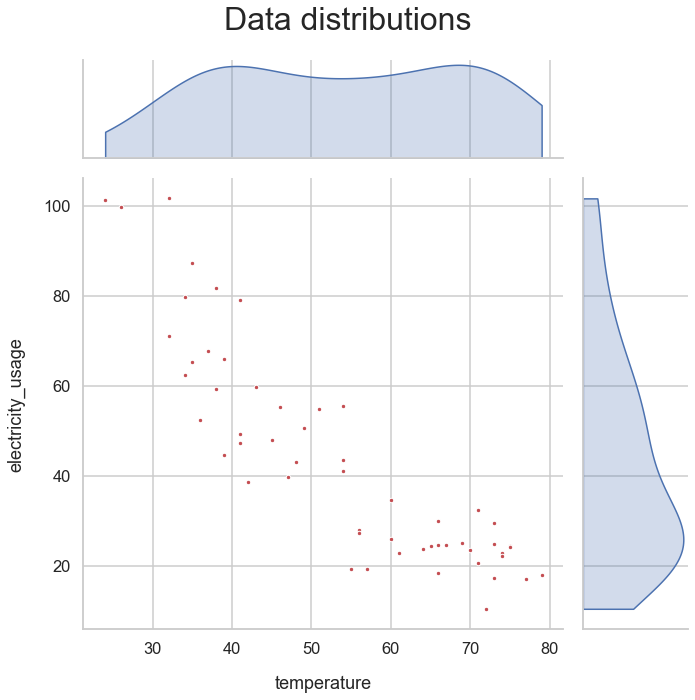

In [31]:
sns.set_style('whitegrid')
sns.set_context("talk")
plt.figure()

g = sns.JointGrid(data=energy, x='temperature', y='electricity_usage', height=10, ratio=4)
g.plot_joint(sns.scatterplot, alpha=1, color="r", linewidth=1, s=20)
g.plot_marginals(sns.kdeplot, shade=True, cut=0)
sns.despine()
g.fig.suptitle('Data distributions', fontsize=32)
g.fig.subplots_adjust(top=0.88) # Reduce plot to make room
g.fig.tight_layout()

plt.show()

#### `'temperature'` column data is close to normal distribution, but `'electricity_usage'` is right-skewed (the most number of observations have low values) - all `'electricity_usage'` observations will be transform by using a few the most common function:
- BoxCox (*normalization*),
- RobustScaler,
- QuantileTransformer,
- minmax_scale.

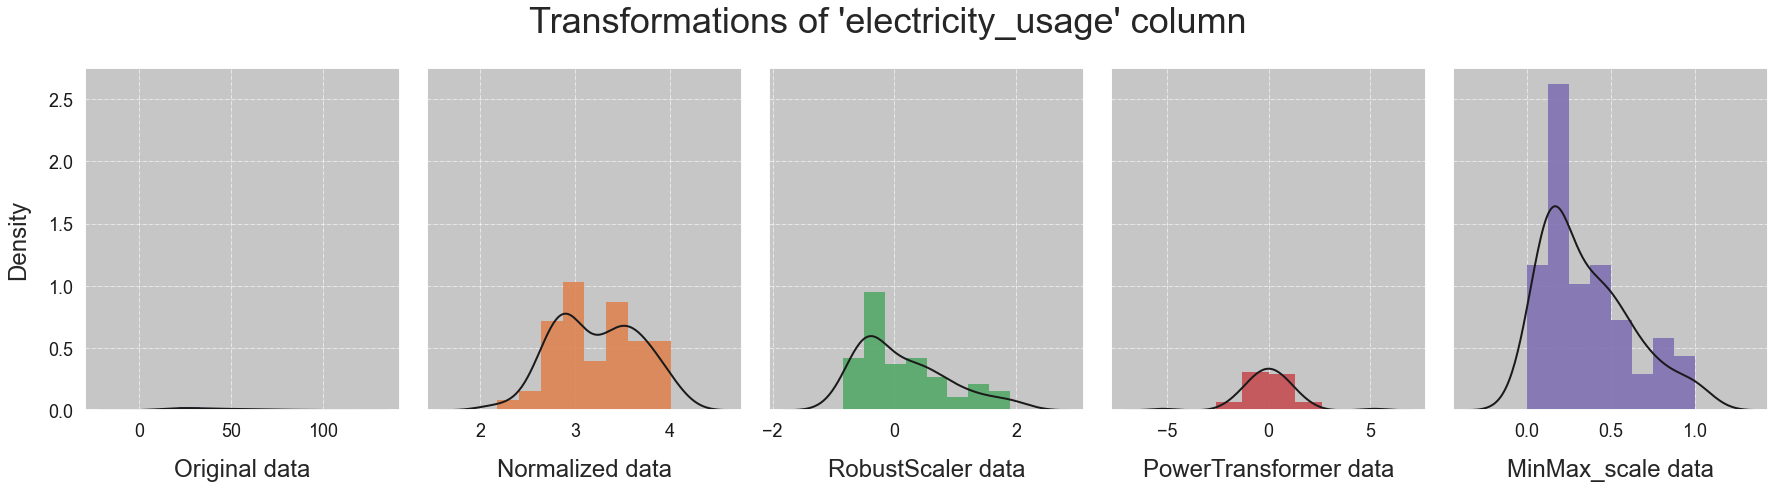

In [11]:
from scipy import stats # for Box-Cox Transformation
from sklearn.preprocessing import minmax_scale, RobustScaler, QuantileTransformer

global_plot_sets()
fig, ax = plt.subplots(1, 5, figsize=(25, 7), sharey=True)

function_titles = ['Original data', 'Normalized data', 'RobustScaler data', 
                   'PowerTransformer data', 'MinMax_scale data']
# round up bins number by one
bin_num = int(np.ceil(np.sqrt(energy.shape[0])))

## Function to transform original data from 'energy' DataFrame
def data_transformations(data_name):
    # reshape data to make 'fit_transform' operations
    data_reshape = np.array(data_name).reshape(-1,1)
    
    Normalized_data = stats.boxcox(data_name)
    RobustScaler_data = RobustScaler(quantile_range=(25, 75)).fit_transform(data_reshape)
    PowerTransformer_data = QuantileTransformer(output_distribution='normal', 
                                                n_quantiles=len(data_name)).fit_transform(data_reshape)
    Scaled_data = minmax_scale(data_name)
    
    return [data_name, Normalized_data[0], RobustScaler_data, 
            PowerTransformer_data, Scaled_data]


## Results of 'energy' DataFrame transformations as a list 
transformed_energy_col = data_transformations(energy['electricity_usage'])

def Make_dataframe():
    _ = []
    df = pd.DataFrame(columns=function_titles)
    for i in range(0, len(function_titles)):
        _.append(np.array(transformed_energy_col[i]).flatten())
        df[df.columns[i]] = _[i]    
    return df

df_transformed_data = Make_dataframe()

for i in range(0, len(function_titles)):
    sns.histplot(data=df_transformed_data, x=function_titles[i], color=sns.color_palette('deep')[i],
                 edgecolor="none", alpha=0.9, bins=bin_num, ax=ax[i], stat='density')
    sns.kdeplot(data=df_transformed_data, x=function_titles[i], color='k',
                linewidth=2, alpha=1, ax=ax[i])

plt.suptitle("Transformations of 'electricity_usage' column", fontsize = 36, y=0.98)
plt.tight_layout()
plt.show()

In [12]:
# Transformation results presented in one array to use it in the later calculations
transformed_temperature_data = data_transformations(energy['temperature'])

# Results as the DataFrames
def DataFrame_with_transformation(i):
    X_temperature = np.array(transformed_temperature_data[i]).reshape(-1,1)
    if (i==0 or i==1 or i==4):
        y_transformed = transformed_energy_col[i]
    else:
        y_transformed = transformed_energy_col[i][:, 0]
    return pd.DataFrame({'X': X_temperature.flatten(), 'y': y_transformed})

---

# Linear regression methods

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Polynomial functions using to compare will have degrees between 1. and 5. - higher degree values than 5. could be a reason of overfitting the final model.

## **Polynomial regression** (1. to 5. degrees)

In [14]:
from sklearn.preprocessing import PolynomialFeatures

model = LinearRegression()

col_names = ['X', 'y', 'y_poly_predicted', 'RMSE', 'R2', 'poly_degree', 'func_name']

def poly_regression(col):
    df = DataFrame_with_transformation(col)
    x, y = df.iloc[:, 0:1], df.iloc[:, 1:]
    poly_df = pd.DataFrame(data={'X': np.tile(df['X'], 5), 
                                 'y': np.tile(df['y'], 5)},
                           columns=col_names)
    
    for n in range(1, 6):
        polynomial_features = PolynomialFeatures(degree = n)
        x_poly = polynomial_features.fit_transform(x)
        y_poly = model.fit(x_poly, y).predict(x_poly)
        rmse = np.sqrt(mean_squared_error(y, y_poly))
        r2 = r2_score(y, y_poly, multioutput = 'variance_weighted')
        
        ## For the same 'n' we have got list of the constant parameters as below
        func_name = function_titles[col]
        const_values = [rmse, r2, n, func_name]
        
        index_1 = len(df) * (n - 1)
        index_2 = index_1 + len(energy)
        
        poly_df.iloc[index_1:index_2, 2] = np.array(y_poly).flatten()
        poly_df.iloc[index_1:index_2, 3:] = const_values
                
    return poly_df

In [15]:
def poly_params_concat():
    df_name = [poly_regression(i) for i in np.arange(0,5)]
    return pd.concat(df_name).reset_index(drop=True)
    
# All results for regressions with polynomial algorythm made
poly_params_results = poly_params_concat()
poly_params_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 1375 non-null   float64
 1   y                 1375 non-null   float64
 2   y_poly_predicted  1375 non-null   object 
 3   RMSE              1375 non-null   object 
 4   R2                1375 non-null   object 
 5   poly_degree       1375 non-null   object 
 6   func_name         1375 non-null   object 
dtypes: float64(2), object(5)
memory usage: 75.3+ KB


### Everything except 'func_name' should be the numbers, so we need to convert columns 2-5 to numeric type.

In [16]:
cols = ['y_poly_predicted', 'RMSE', 'R2', 'poly_degree']
poly_params_results[cols] = poly_params_results[cols].apply(lambda x: pd.to_numeric(x, errors='ignore'))

poly_params_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375 entries, 0 to 1374
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 1375 non-null   float64
 1   y                 1375 non-null   float64
 2   y_poly_predicted  1375 non-null   float64
 3   RMSE              1375 non-null   float64
 4   R2                1375 non-null   float64
 5   poly_degree       1375 non-null   int64  
 6   func_name         1375 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 75.3+ KB


## Before comparing the results we have to remember that the best RMSE value means the lowest (ideally RMSE=0), but the best R2 means the highest value (ideally R2=1).

In [19]:
def best_poly_params():
    res = poly_params_results
    for func_name in function_titles:
        _ = res[res['func_name'] == func_name].reset_index(drop=True)
        best_index = np.argmax(_.loc[:, 'R2'])
        best_RMSE, best_R2, best_poly_degree = _.loc[best_index, ['RMSE', 'R2', 'poly_degree']]
        print(f'"{func_name}" best fit values (RMSE={best_RMSE:.3f}, R2={best_R2:.3f})\n\
        are for {best_poly_degree}. polynomial function degree \n')

# Best results for all regressions with polynomial algorythm made
best_poly_params_results = best_poly_params()

"Original data" best fit values (RMSE=9.294, R2=0.847)
        are for 5. polynomial function degree 

"Normalized data" best fit values (RMSE=0.187, R2=0.815)
        are for 5. polynomial function degree 

"RobustScaler data" best fit values (RMSE=0.280, R2=0.847)
        are for 5. polynomial function degree 

"PowerTransformer data" best fit values (RMSE=0.861, R2=0.594)
        are for 5. polynomial function degree 

"MinMax_scale data" best fit values (RMSE=0.102, R2=0.847)
        are for 5. polynomial function degree 



## **Conclusion**: Optimal polynomial regression method is `'MinMax_scale data'` with ***n=2*** (2. degree polynomial function used) - higher **'n'** values do not give better results, but makes the final model more complex only.

### All RMSE and R2 results are shown in the plots below

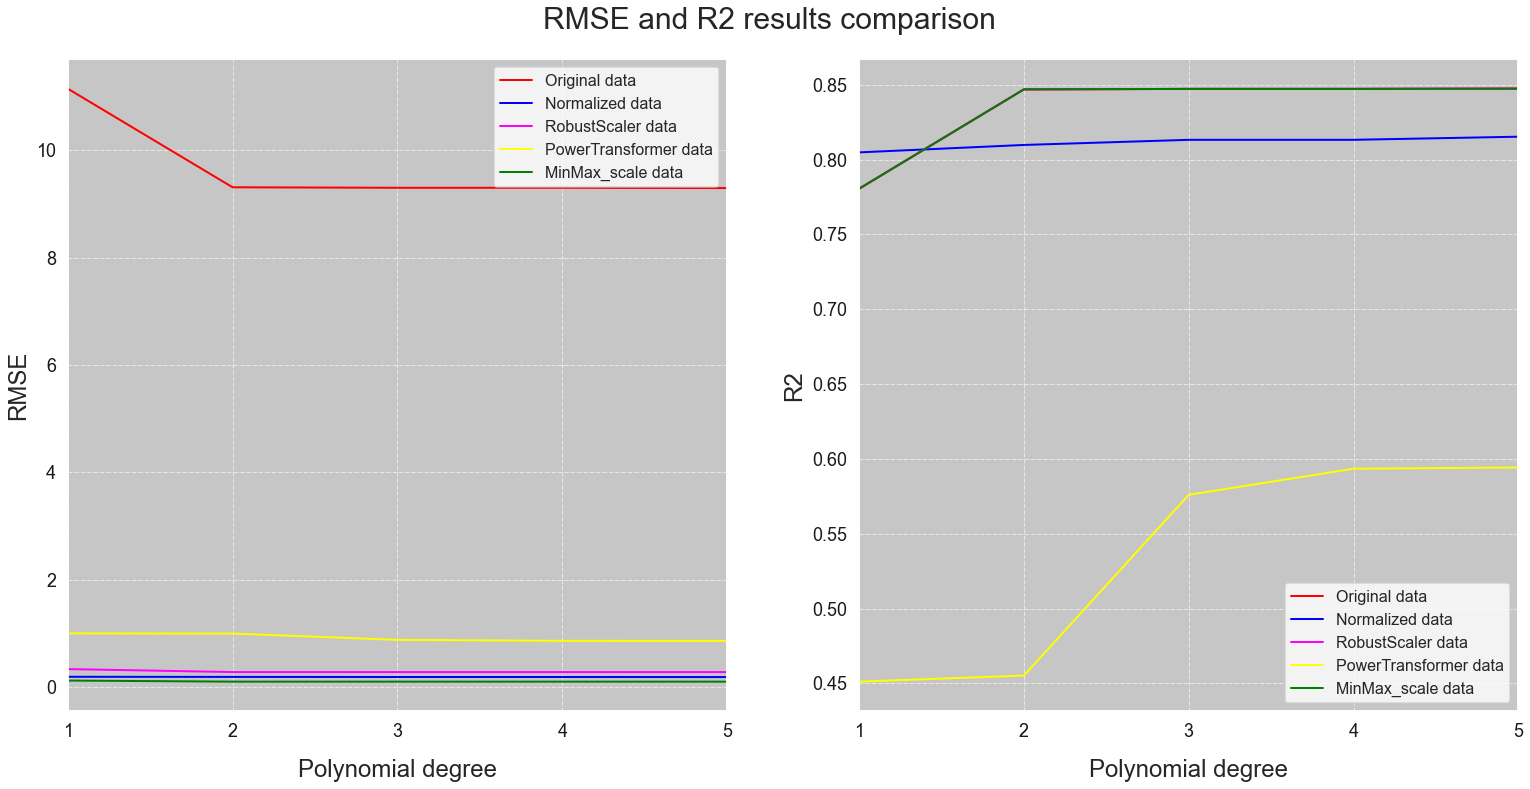

In [20]:
global_plot_sets()
plt.figure(figsize=(26, 12))

## Finding unique value of RMSE or R2 in function by poly degree number
def func_splitted(func, degree, param):
    _ = func.loc[func['poly_degree'] == degree][param]
    param_value = float(np.unique(_))
    return param_value

def params_plot(param):
    indexes_1 = np.arange(0, 5, 1)  # loop indexes range
    indexes_2 = indexes_1 + 1  # polynomial degrees range
    colors = ['red', 'blue', 'magenta', 'yellow', 'green']
    
    for num, colors, data_type in zip(indexes_1, colors, function_titles):
        # List of RMSE or R2 values for all functions
        y = [func_splitted(poly_regression(num), degree, param) for degree in indexes_2]
        plt.plot(indexes_2, y, linewidth = 2, color = colors, label = data_type)
        plt.xlabel('Polynomial degree')
        plt.ylabel(param, labelpad=6)
        plt.xticks(ticks=indexes_2)
        plt.xlim(1, 5)
        plt.legend()

plt.subplot(121)
params_plot('RMSE')
plt.subplot(122)
params_plot('R2')
        
plt.suptitle('RMSE and R2 results comparison', fontsize=30, y=0.94)

plt.show()

### After making DataFrames we need to reorganize data by ascending order on x-axis - only then it is possible to draw the plots with polynomial approximations properly.

In [21]:
## Sorting x values in the DataFrames from poly_regression() function

def sorted_x_values(func, i):
    ## Only input (X) and output (y_poly_predicted) values
    ## from all DataFrame columns are needed.
    _ = func.loc[func['poly_degree'] == i][['X', 'y_poly_predicted']]
    return _.sort_values('X')

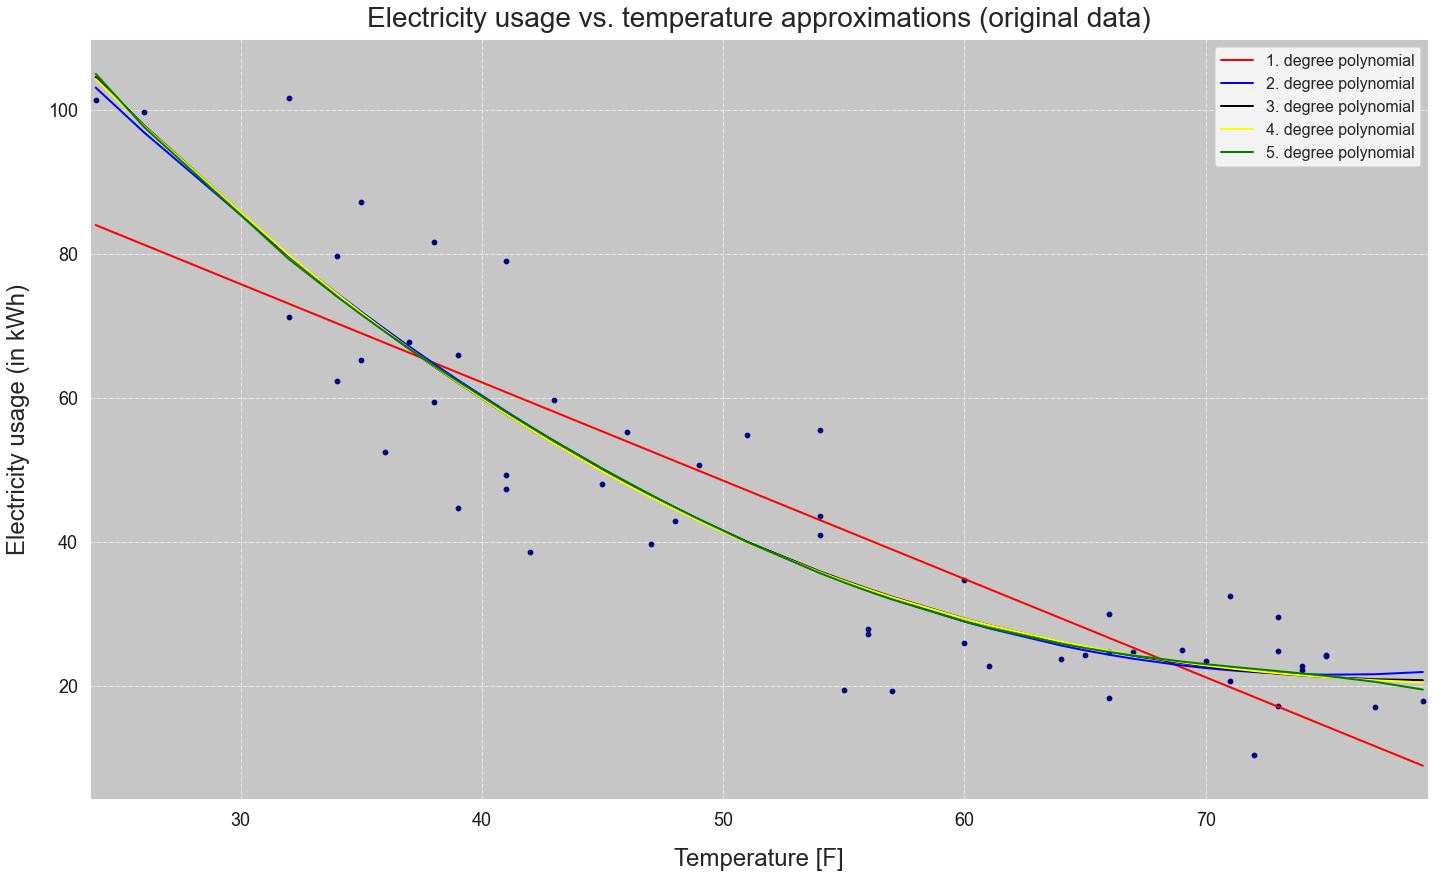

In [22]:
global_plot_sets()
plt.figure(figsize=(24, 14))

numbers_range = np.arange(1, 6)
colors = ['red', 'blue', 'black', 'yellow', 'green']
labels_name = [str(x) + '. degree polynomial' for x in numbers_range]

for index_1, index_2, colors in zip(numbers_range, numbers_range - 1, colors):
    x_poly_original_sorted = sorted_x_values(poly_regression(0), index_1)
    plt.plot(x_poly_original_sorted['X'], x_poly_original_sorted['y_poly_predicted'],
             linewidth = 2, aa=True, color = colors, label = labels_name[index_2])

plt.scatter(energy['temperature'], energy['electricity_usage'], c = 'navy', marker = 'o', s = 18)
plt.xlabel('Temperature [F]')
plt.ylabel('Electricity usage (in kWh)')
plt.xlim(energy['temperature'].min() - 0.25, energy['temperature'].max() + 0.25)
plt.title('Electricity usage vs. temperature approximations (original data)')
plt.legend()

plt.show()

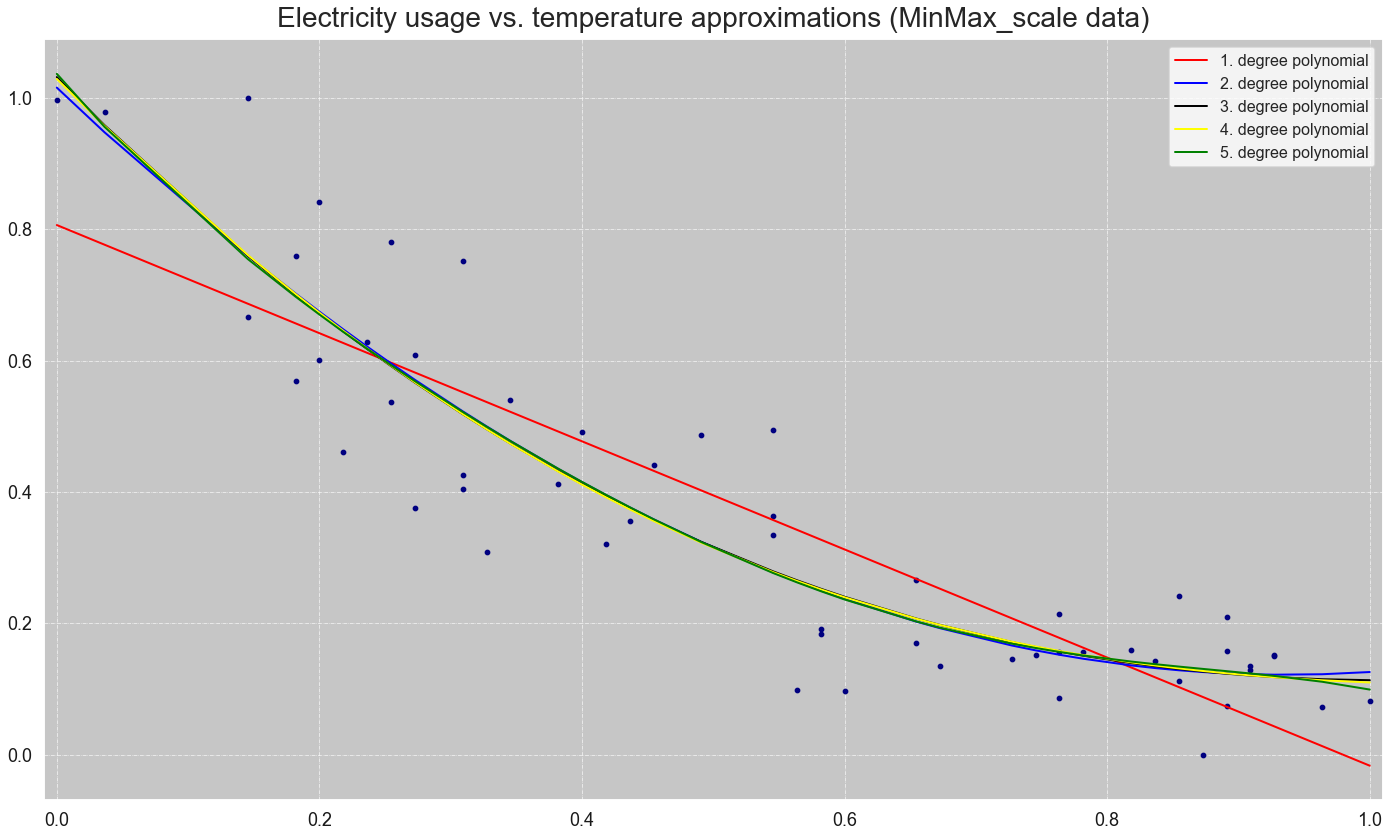

In [23]:
global_plot_sets()
plt.figure(figsize=(24, 14))

numbers_range = np.arange(1, 6)
colors = ['red', 'blue', 'black', 'yellow', 'green']
labels_name = [str(x) + '. degree polynomial' for x in numbers_range]

for index_1, index_2, colors in zip(numbers_range-1, numbers_range, colors):
    x_poly_original_sorted = sorted_x_values(poly_regression(4), index_2)
    plt.plot(x_poly_original_sorted['X'], x_poly_original_sorted['y_poly_predicted'],
             linewidth = 2, aa=True, color = colors, label = labels_name[index_1])

plt.scatter(DataFrame_with_transformation(4)['X'], DataFrame_with_transformation(4)['y'], c = 'navy', marker = 'o', s = 18)
plt.xlim(DataFrame_with_transformation(4)['X'].min() - 0.01, DataFrame_with_transformation(4)['y'].max() + 0.01)
plt.title('Electricity usage vs. temperature approximations (MinMax_scale data)')
plt.legend()

plt.show()